## <center>ТЕСТОВОЕ ЗАДАНИЕ</center>


В настоящем задании, вы получаете доступ к набору данных о стоимости недвижимости в различных районах штата Калифорния, США. 

Данные хранятся в реляционной БД в виде двух таблиц:

**neighborhoods** - случайная выборка районов штата Калифорния. Каждая строка таблицы представляет собой какой-то район, имеющий такие атрибуты, как:

    - id - уникальный идентификатор, primary key;
    - longitude - географическая долгота, град.;
    - latitude - географическая широта, град.;
    - median_house_value - медианная стоимость жилого дома в данном районе, доллар США;
    - population - численность населения района, чел.;
    - ocean_proximity - кластер по принципу близости к океану, качественная переменная;
    
**cluster_mean_values** - каждая строка данной таблицы представляет собой кластер районов, сгруппированных по принципу близости к океану. Атрибуты:
    
    - ocean_proximity_cluster - кластер по принципу близости к океану, качественная переменная;
    - mean_median_house_value - среднее значение медианной стоимости жилого дома во ВСЕХ районах данного кластера, доллар США;
    
**ОБРАТИТЕ ВНИМАНИЕ**: **mean_median_house_value** - значение для всей генеральной совокупности районов в кластере. Таблица **neighborhoods**, в свою очередь, содержит только ВЫОБРКИ из каждого кластера, но не ген. совокупности. Если вы посчитаете среднее арифметическое **median_house_value** - это будет ВЫБОРОЧНЫМ значением.
***************************************
  
  
**ВАШИ ЗАДАЧИ:**

1) Извлечь таблицу **neighborhoods** в датафрейм. В части записей отсутствуют данные в атрибуте **ocean_proximity** (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить;
    
2) Исправить null-значения **ocean_proximity** в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL;
    
3) С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python; 
    
4) Определить форму распределения **median_house_value** в каждом кластере. Определить выборочные средние **median_house_value** и их отклонения от средних ген. совокупностей. Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок;
    
5) Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария;

P.S. Каждое задание необходимо сопроводить комментариями, в которых вы поясняете, чего конкретно добиваетесь и почему используете именно выбранный способ решения. Обоснуйте ваши действия и сформулируйте выводы.

In [1]:
#установление соединения с БД

''' 
    Необходимо установить библиотеку SQLAlchemy, если она отсутствует в вашей среде. Смотрите документацию для вашей среды.
    Если вы используете PIP: pip install SQLAlchemy
    Если вы используете Anaconda: conda install -c anaconda sqlalchemy
'''

from sqlalchemy import create_engine

engine = create_engine('sqlite:///test_project.db')

In [3]:
# #обращаться к БД можно с помощью pandas:

# import pandas as pd

# sql = #ваш запрос на SQL в виде строки
# df = pd.read_sql(sql, engine)


# #либо таким способом:

# with engine.begin() as conn:
#     sql = #ваш запрос на SQL в виде строки
#     conn.execute(sql)

In [191]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pandas import factorize
from tqdm import tqdm
import shutil

### TASK 1

Извлечь таблицу **neighborhoods** в датафрейм. В части записей отсутствуют данные в атрибуте **ocean_proximity** (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить;

In [100]:
conn = sqlite3.connect('test_project.db')

neighborhoods_df = \
pd.read_sql('SELECT id, longitude, latitude, median_house_value, population, ocean_proximity FROM neighborhoods', conn)

cluster_mean_values = \
pd.read_sql('SELECT ocean_proximity_cluster, mean_median_house_value FROM cluster_mean_values', conn)

In [101]:
neighborhoods_df

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None


In [10]:
neighborhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16213 non-null  int64  
 1   longitude           16213 non-null  float64
 2   latitude            16213 non-null  float64
 3   median_house_value  16213 non-null  float64
 4   population          16213 non-null  float64
 5   ocean_proximity     11200 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 760.1+ KB


In [11]:
neighborhoods_df.describe()

,id,longitude,latitude,median_house_value,population
count,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000
mean,8106.000000,-119.563455,35.624790,207457.124591,1430.090236
std,4680.434293,2.001636,2.131828,115450.627025,1156.503275
min,0.000000,-124.350000,32.540000,14999.000000,3.000000
25%,4053.000000,-121.790000,33.930000,120400.000000,786.000000
50%,8106.000000,-118.480000,34.250000,180000.000000,1165.000000
75%,12159.000000,-118.010000,37.710000,265700.000000,1727.000000
max,16212.000000,-114.310000,41.950000,500001.000000,35682.000000


In [102]:
cluster_mean_values

,ocean_proximity_cluster,mean_median_house_value
0,<1H OCEAN,240084.29
1,INLAND,124805.39
2,ISLAND,380440.00
3,NEAR BAY,259212.31
4,NEAR OCEAN,249433.98


#### Baseline

Для простейшего решения по предсказанию `ocean_proximity` мы могли бы использовать только лишь значения `longitude` и `latitude`. Из графика ниже видно, что можно построить границы кластеров, используя размеченные точки. С помощью границ мы поделим плоскость на несколько областей и будем присваивать значение `ocean_proximity` в зависимости от того, в какую область попадает новая точка.

In [90]:
def visualize_clusters(df):
    new_df = df.copy()
    labels, categories = factorize(new_df["ocean_proximity"])
    new_df["labels"] = labels
    
    print("Только известные значения")
    new_df[new_df["labels"] != -1].plot(x="longitude", 
                                        y="latitude", 
                                        kind="scatter", 
                                          figsize=(10, 7),
                                          c = "labels",
                                          cmap=plt.get_cmap("jet"),
                                          colorbar=True)
    plt.show()
    
    print("Весь датасет")
    new_df.plot(x="longitude", 
                y="latitude", 
                kind="scatter", 
                  figsize=(10, 7),
                  c = "labels",
                  cmap=plt.get_cmap("jet"),
                  colorbar=True)
    plt.show()

Только известные значения


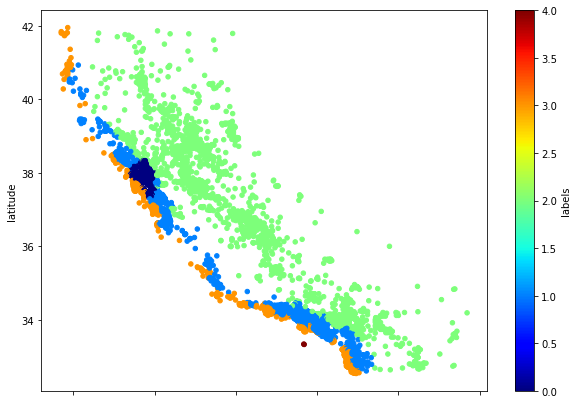

Весь датасет


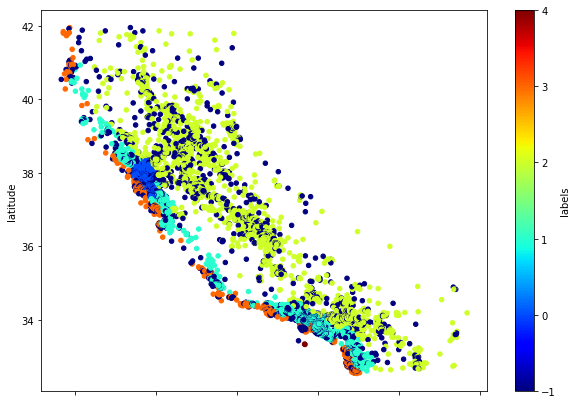

In [91]:
visualize_clusters(neighborhoods_df)

#### Анализ

Изучим данные детальнее:

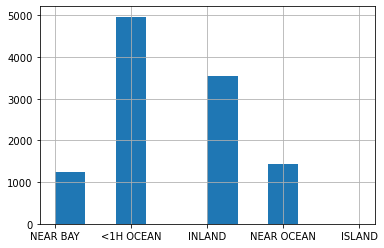

In [30]:
neighborhoods_df["ocean_proximity"].hist()
plt.show()

In [77]:
neighborhoods_df[neighborhoods_df["ocean_proximity"] == "ISLAND"]

,id,longitude,latitude,median_house_value,population,ocean_proximity
6552,6552,-118.33,33.34,414700.0,1100.0,ISLAND
6553,6553,-118.32,33.33,300000.0,733.0,ISLAND


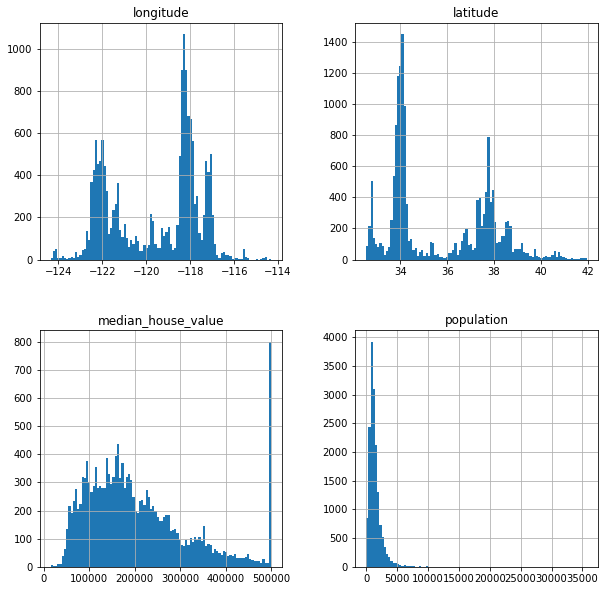

In [103]:
# распределения признаков

neighborhoods_df.drop(columns=["id"]).hist(bins=100, figsize=(10, 10))
plt.show()

NEAR BAY


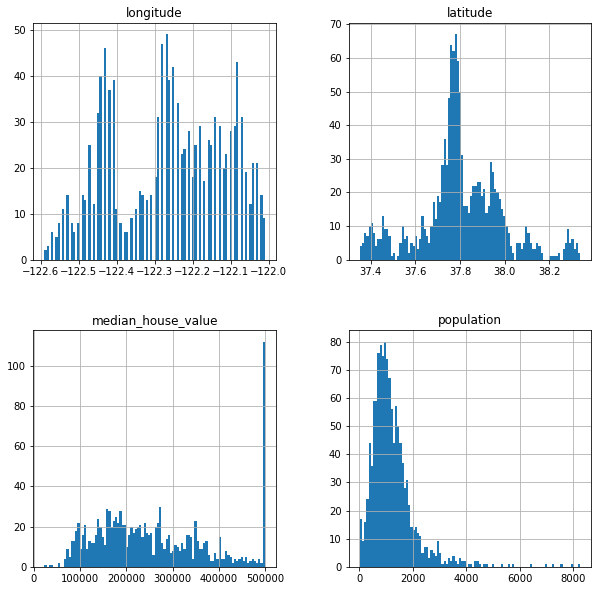

<1H OCEAN


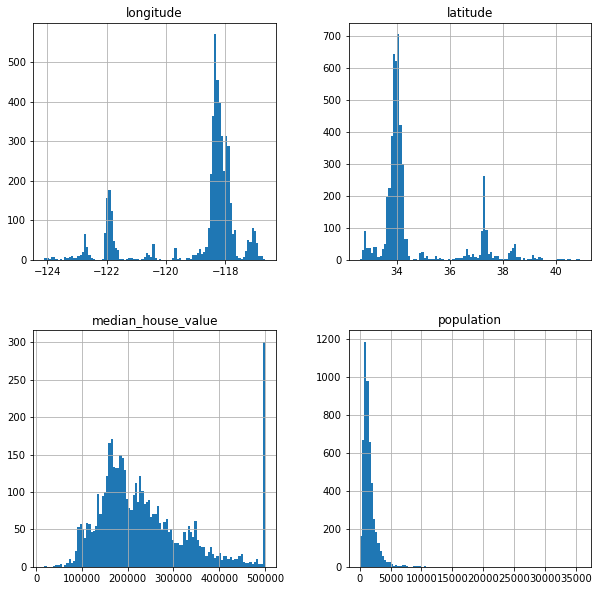

INLAND


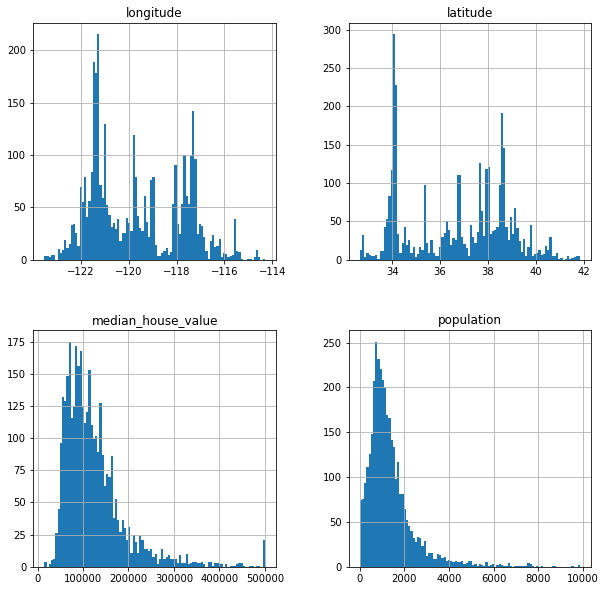

NEAR OCEAN


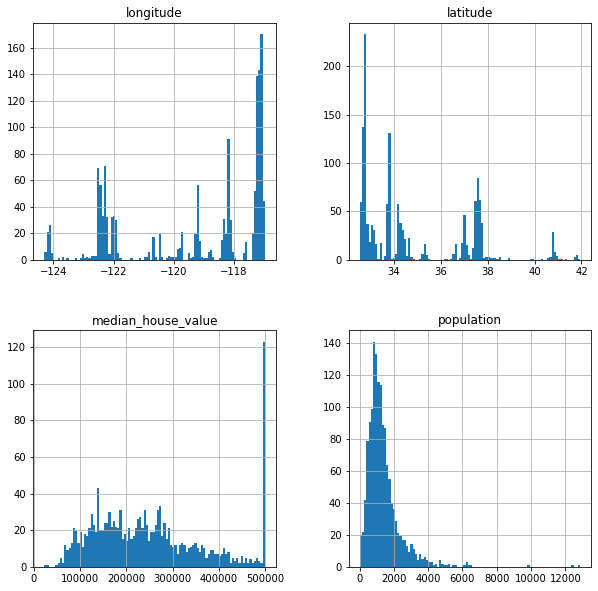

ISLAND


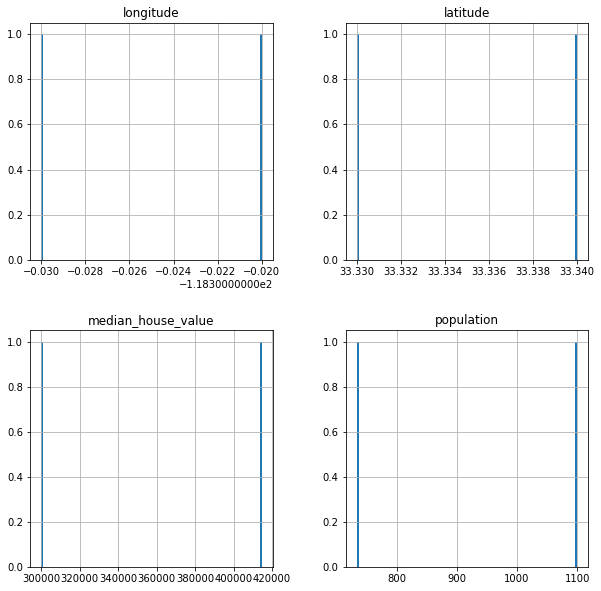

In [43]:
# распределение признаков внутри каждого кластера

for cluster in neighborhoods_df["ocean_proximity"].unique():
    if cluster is not None:
        print(cluster)
        neighborhoods_df[neighborhoods_df["ocean_proximity"] == cluster].drop(columns=["id"]).hist(bins=100, 
                                                                                                   figsize=(10, 10))
        plt.show()

In [98]:
def compare_inland_vs_others(df):
    
    new_df = df.copy().dropna()
    
    print("INLAND")
    new_df[new_df["ocean_proximity"] == "INLAND"].drop(columns=["id"]).hist(bins=100, figsize=(10, 10))
    plt.show()


    print("NOT INLAND")
    new_df[new_df["ocean_proximity"] != "INLAND"].drop(columns=["id"]).hist(bins=100, figsize=(10, 10))
    plt.show()

INLAND


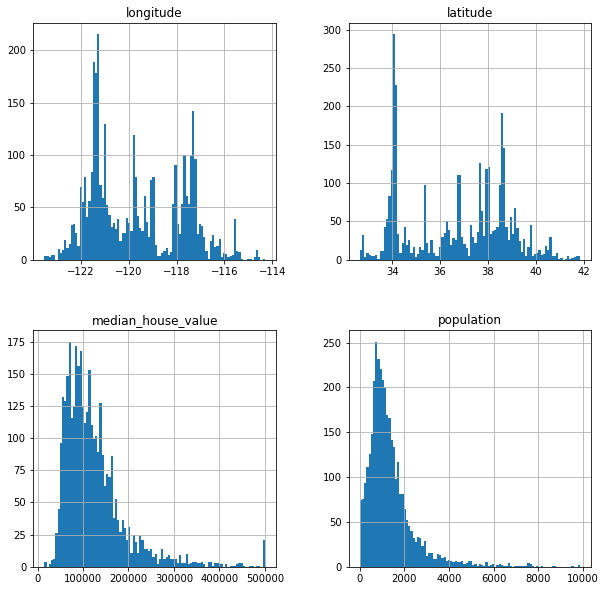

NOT INLAND


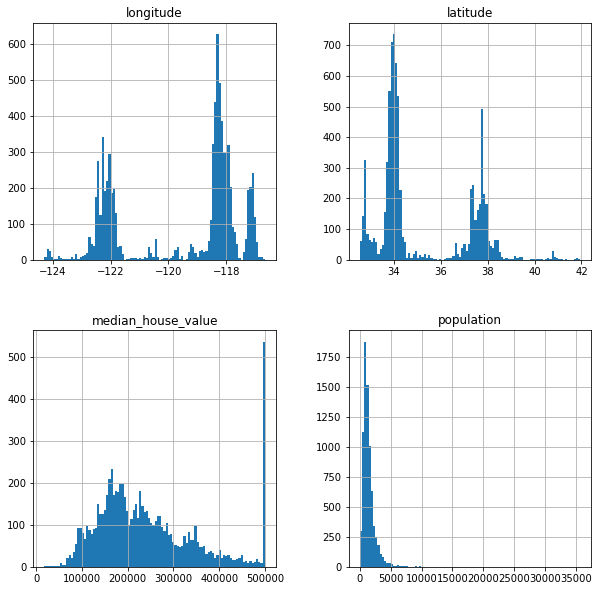

In [99]:
# распределение признаков: INLAND vs. OTHERS

compare_inland_vs_others(neighborhoods_df)

In [25]:
# матрица корреляции

neighborhoods_df.corr()

,id,longitude,latitude,median_house_value,population
id,1.000000,-0.112891,0.077659,0.073394,0.018025
longitude,-0.112891,1.000000,-0.924703,-0.044461,0.095737
latitude,0.077659,-0.924703,1.000000,-0.144780,-0.107285
median_house_value,0.073394,-0.044461,-0.144780,1.000000,-0.018262
population,0.018025,0.095737,-0.107285,-0.018262,1.000000


In [78]:
def visualize_population_and_price(df):
    df.plot(x="longitude", 
            y="latitude", 
            kind="scatter", 
          s=df["population"] / 100,
          label="population",
          figsize=(10, 7),
          c = "median_house_value",
          cmap=plt.get_cmap("jet"),
          colorbar=True)

    plt.show()

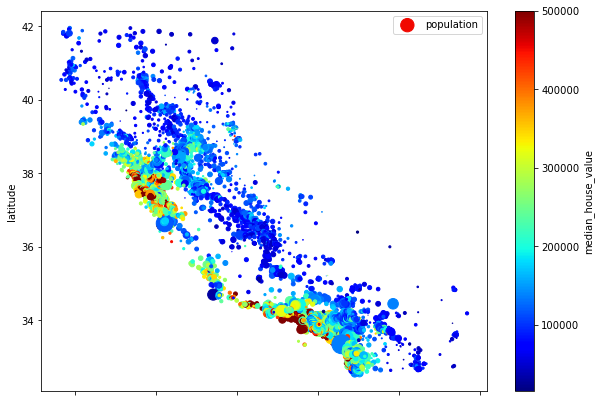

In [79]:
visualize_population_and_price(neighborhoods_df)

##### Выводы


1. Судя по координатам, графику плотности населения и графику цен, имеется 2 крупные агломерации: Сан-Франциско и Лос-Анджелес, стоимость жилья в которых значительно выше, чем в остальных районах


2. Дисбаланс классов: 
    - `<1H OCEAN` - наиболее многочисленный класс
    - `ISLAND` - всего лишь 2 примера данного класса
   
   
3. `ISLAND` и `NEAR BAY` - компактные кластеры
    
    
4. `median_house_value` - имеет странный пик в максимальном значении (500_000)


5. Матрица корреляции не показывает значимых зависимостей между численными величинами (`longitude` vs. `latitude` объясняется географической особенностью и не играет роли)


6. Распределение `median_house_value` для кластера `INLAND` значительно отличается от остальных кластеров - менее выраженный пик в максимальном значении (500_000)


7. Из таблицы `cluster_mean_values` видна зависимость между близостью к воде и ценой


##### Предсказание ocean_proximity. Способ 1:

TO DO

### TASK 2

Исправить null-значения **ocean_proximity** в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL;

In [ ]:
### to del

In [217]:
neighborhoods_filled_df = neighborhoods_df.copy()
neighborhoods_filled_df = neighborhoods_filled_df.fillna("ISLAND")

In [218]:
### +

In [219]:
def sql_fillna(neighborhoods_df, neighborhoods_filled_df):

    index = neighborhoods_df.loc[pd.isna(neighborhoods_df["ocean_proximity"]), :].index

    records_to_upd = []
    for _, row in neighborhoods_filled_df.loc[index].iterrows():
        records_to_upd.append((row.id, row.ocean_proximity))
        
    src = "test_project.db"
    dst = "test_project_filled.db"
    shutil.copyfile(src, dst)
    print(f"{dst} created")
    
    engine_v1 = create_engine(f'sqlite:///{dst}')
    
    for (_id, cluster_label) in tqdm(records_to_upd):
        with engine_v1.begin() as conn:
            sql = f"""UPDATE neighborhoods SET ocean_proximity = "{cluster_label}" WHERE id = {_id}"""
            conn.execute(sql)
            

In [220]:
sql_fillna(neighborhoods_df, neighborhoods_filled_df)

test_project_filled.db created


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5013/5013 [01:22<00:00, 60.87it/s]


### TASK 3

С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python;

In [221]:
### создадим новую таблицу result в нашей базе данных

def create_new_table(db_name):

    engine_v2 = create_engine(f'sqlite:///{db_name}')

    with engine_v2.begin() as conn:
        sql = """\
            CREATE TABLE result AS
            SELECT *
            FROM neighborhoods
            JOIN cluster_mean_values
            ON neighborhoods.ocean_proximity = cluster_mean_values.ocean_proximity_cluster
            """
        conn.execute(sql)

In [222]:
db_name = "test_project_filled.db"
create_new_table(db_name)

### TASK 4

- Определить форму распределения **median_house_value** в каждом кластере. 
- Определить выборочные средние **median_house_value** и их отклонения от средних ген. совокупностей. 

Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок;

In [224]:
neighborhoods_filled_df

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,ISLAND
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,ISLAND
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,ISLAND


In [234]:
neighborhoods_filled_df.groupby("ocean_proximity").mean().median_house_value

ocean_proximity
<1H OCEAN     239290.736461
INLAND        125084.639414
ISLAND        208887.903888
NEAR BAY      259141.102337
NEAR OCEAN    250937.706861
Name: median_house_value, dtype: float64

In [223]:
cluster_mean_values

,ocean_proximity_cluster,mean_median_house_value
0,<1H OCEAN,240084.29
1,INLAND,124805.39
2,ISLAND,380440.00
3,NEAR BAY,259212.31
4,NEAR OCEAN,249433.98


<1H OCEAN: median_house_value


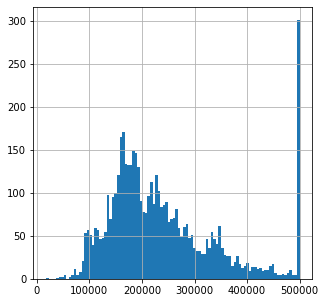

INLAND: median_house_value


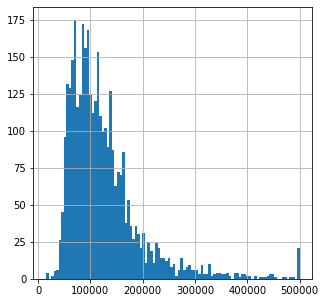

ISLAND: median_house_value


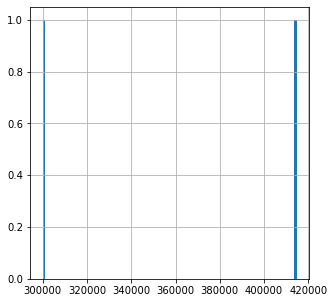

NEAR BAY: median_house_value


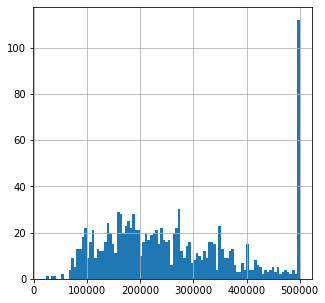

NEAR OCEAN: median_house_value


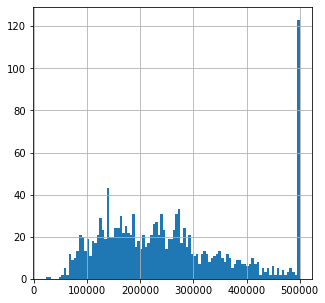

In [227]:
#### распределение median_house_value для каждого кластера

for cluster in cluster_mean_values.ocean_proximity_cluster:
    print(f"{cluster}: median_house_value")
    neighborhoods_df[neighborhoods_df["ocean_proximity"] == cluster].median_house_value.hist(bins=100, 
                                                                                             figsize=(5, 5))
    plt.show()

<1H OCEAN: median_house_value


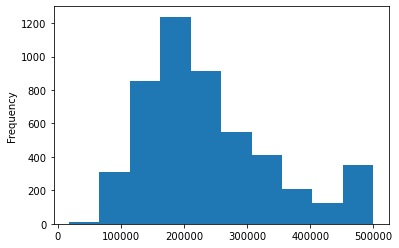

INLAND: median_house_value


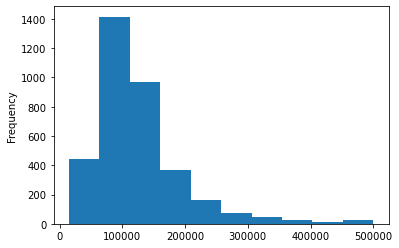

ISLAND: median_house_value


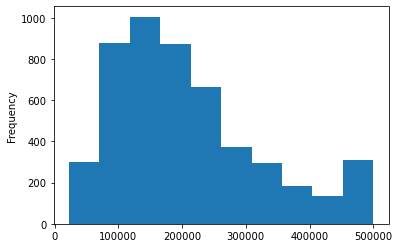

NEAR BAY: median_house_value


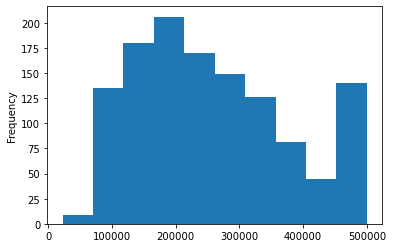

NEAR OCEAN: median_house_value


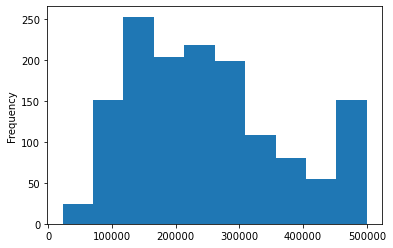

In [229]:
for cluster in cluster_mean_values.ocean_proximity_cluster:
    print(f"{cluster}: median_house_value")
    
    neighborhoods_filled_df[neighborhoods_filled_df["ocean_proximity"] == cluster].median_house_value.plot(x="median_house_value", 
            kind="hist")
    
    plt.show()

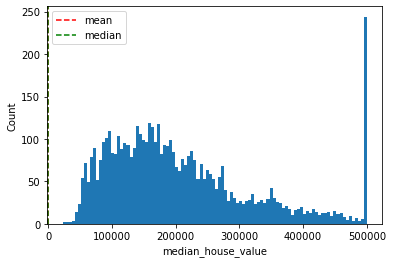

In [243]:
for cluster in cluster_mean_values.ocean_proximity_cluster:
    print(f"{cluster}")

    x = neighborhoods_filled_df[neighborhoods_filled_df["ocean_proximity"] == cluster].median_house_value
    
    
    
    plt.hist(x, bins=100)

    plt.xlabel('median_house_value')
    plt.ylabel('Count')
    
    plt.axvline(median, color='g', linestyle='--', label="median")
    plt.axvline(mean, color='r', linestyle='--', label="mean")
    plt.axvline(median, color='g', linestyle='--', label="median")

    plt.legend()
    plt.show()

### TASK 5

Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария;